#**Telangana Academic Grand ​Challenge on Climate Change**

Team Name : Hack and Cheese
 ,

> Hyagreev Rethinavel

>  Viboosithasri N S

> Nakul R

>  Suberus Heartrisha G


##Model Used to predict the occurrences of heat waves and the Air Quality Index (AQI) : 
#**TFT - Temporal Fusion Transformer**

#2. AQI PREDICTION AND FORECASTING

Installling Libraries

In [ ]:
#Installing Pytorch_Lightning Libraries

pip install pytorch-lightning==1.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Installing Pytorch_Forecasting Libraries

pip install pytorch_forecasting


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Importing Libraries

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import matplotlib.pyplot as plt

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting import NaNLabelEncoder

In [ ]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

Reading the data and Preprocessing the data

In [ ]:
#Reading Data from the folder

data=pd.read_csv("Final_AQI.csv")

In [ ]:
#Date Formatting

data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

In [ ]:
#Printing the Data

data

,City,Date,PM2_5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,67.450578,118.127103,0.92,18.22,17.15,23.483476,0.92,27.64,133.36,0.00000,0.020000,0.000000,166.463582,0.666
1,Ahmedabad,2015-01-02,67.450578,118.127103,0.97,15.69,16.46,23.483476,0.97,24.55,34.06,3.68000,5.500000,3.770000,166.463582,0.666
2,Ahmedabad,2015-01-03,67.450578,118.127103,17.40,19.30,29.70,23.483476,17.40,29.07,30.70,6.80000,16.400000,2.250000,166.463582,0.666
3,Ahmedabad,2015-01-04,67.450578,118.127103,1.70,18.48,17.97,23.483476,1.70,18.59,36.08,4.43000,10.140000,1.000000,166.463582,0.666
4,Ahmedabad,2015-01-05,67.450578,118.127103,22.10,21.42,37.76,23.483476,22.10,39.33,39.31,7.01000,18.890000,2.780000,166.463582,0.666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28658,Visakhapatnam,2020-06-27,15.020000,50.940000,7.68,25.06,19.54,12.470000,0.47,8.55,23.30,2.24000,12.070000,0.730000,41.000000,1.000
28659,Visakhapatnam,2020-06-28,24.380000,74.090000,3.42,26.06,16.53,11.990000,0.52,12.72,30.14,0.74000,2.210000,0.380000,70.000000,0.830
28660,Visakhapatnam,2020-06-29,22.910000,65.730000,3.45,29.53,18.33,10.710000,0.48,8.42,30.96,0.01000,0.010000,0.000000,68.000000,0.830
28661,Visakhapatnam,2020-06-30,16.640000,49.970000,4.05,29.26,18.80,10.030000,0.52,9.84,28.30,0.00000,0.000000,0.000000,54.000000,0.830


In [ ]:
data[data['Date'].dt.year<=2019]

,City,Date,PM2_5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,67.450578,118.127103,0.92,18.22,17.15,23.483476,0.92,27.64,133.36,0.00,0.02,0.00,166.463582,0.666
1,Ahmedabad,2015-01-02,67.450578,118.127103,0.97,15.69,16.46,23.483476,0.97,24.55,34.06,3.68,5.50,3.77,166.463582,0.666
2,Ahmedabad,2015-01-03,67.450578,118.127103,17.40,19.30,29.70,23.483476,17.40,29.07,30.70,6.80,16.40,2.25,166.463582,0.666
3,Ahmedabad,2015-01-04,67.450578,118.127103,1.70,18.48,17.97,23.483476,1.70,18.59,36.08,4.43,10.14,1.00,166.463582,0.666
4,Ahmedabad,2015-01-05,67.450578,118.127103,22.10,21.42,37.76,23.483476,22.10,39.33,39.31,7.01,18.89,2.78,166.463582,0.666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28475,Visakhapatnam,2019-12-27,51.790000,118.127103,34.78,48.39,54.01,9.560000,1.24,9.01,34.62,6.72,12.41,4.24,101.000000,0.666
28476,Visakhapatnam,2019-12-28,74.530000,118.127103,4.21,33.50,21.25,9.720000,1.21,6.30,42.20,5.58,9.34,2.23,110.000000,0.666
28477,Visakhapatnam,2019-12-29,41.000000,118.127103,2.37,20.94,13.07,6.780000,0.74,6.25,70.48,3.76,12.04,0.71,133.000000,0.666
28478,Visakhapatnam,2019-12-30,44.790000,118.127103,3.22,35.67,21.58,11.140000,1.06,9.71,77.40,4.41,7.69,2.16,166.463582,0.666


In [ ]:
#Printing the datatypes

data.dtypes

City                  object
Date          datetime64[ns]
PM2_5                float64
PM10                 float64
NO                   float64
NO2                  float64
NOx                  float64
NH3                  float64
CO                   float64
SO2                  float64
O3                   float64
Benzene              float64
Toluene              float64
Xylene               float64
AQI                  float64
AQI_Bucket           float64
dtype: object

In [ ]:
# add time index

date = data['Date'].min()
data["time_idx"] = data['Date'] - date

In [ ]:
#Printing the time index

data["time_idx"]

0          0 days
1          1 days
2          2 days
3          3 days
4          4 days
           ...   
28658   2004 days
28659   2005 days
28660   2006 days
28661   2007 days
28662   2008 days
Name: time_idx, Length: 28663, dtype: timedelta64[ns]

In [ ]:
data["time_idx"]  = data["time_idx"].dt.days

In [ ]:
data["time_idx"]

0           0
1           1
2           2
3           3
4           4
         ... 
28658    2004
28659    2005
28660    2006
28661    2007
28662    2008
Name: time_idx, Length: 28663, dtype: int64

In [ ]:
data.drop(data.loc[data['Date']=="2022-10-31"].index, inplace=True)

In [ ]:
# Converting the dataset coloumns into desired datatypes

data['City'] = data['City'].astype(str)
data['PM2_5'] = data['PM2_5'].astype(float)
data['PM10'] = data['PM10'].astype(float)
data['NO'] = data['NO'].astype(float)
data['NO2'] = data['NO2'].astype(float)
data['NOx'] = data['NOx'].astype(float)
data['NH3'] = data['NH3'].astype(float)
data['CO'] = data['CO'].astype(float)
data['SO2'] = data['SO2'].astype(float)
data['O3'] = data['O3'].astype(float)
data['Xylene'] = data['Xylene'].astype(float)
data['Benzene'] = data['Benzene'].astype(float)
data['Toluene'] = data['Toluene'].astype(float)
data['AQI'] = data['AQI'].astype(float)
data['AQI_Bucket'] = data['AQI_Bucket'].astype(float)

In [ ]:
#Checking for zero null values

data.isnull().sum()

City          0
Date          0
PM2_5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
Xylene        0
AQI           0
AQI_Bucket    0
time_idx      0
dtype: int64

In [ ]:
# Replacing Nan values with zero

data['PM2_5'] = data['PM2_5'].replace(np.nan, 0)
data['PM10'] = data['PM10'].replace(np.nan, 0)
data['NO'] = data['NO'].replace(np.nan, 0)
data['NO2'] = data['NO2'].replace(np.nan, 0)
data['NOx'] = data['NOx'].replace(np.nan, 0)
data['NH3'] = data['NH3'].replace(np.nan, 0)
data['CO'] = data['CO'].replace(np.nan, 0)
data['SO2'] = data['SO2'].replace(np.nan, 0)
data['O3'] = data['O3'].replace(np.nan, 0)
data['Xylene'] = data['Xylene'].replace(np.nan, 0)
data['Benzene'] = data['Benzene'].replace(np.nan, 0)
data['Toluene'] = data['Toluene'].replace(np.nan, 0)
data['AQI'] = data['AQI'].replace(np.nan, 0)
data['AQI_Bucket'] = data['AQI_Bucket'].replace(np.nan, 0)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28663 entries, 0 to 28662
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   City        28663 non-null  object        
 1   Date        28663 non-null  datetime64[ns]
 2   PM2_5       28663 non-null  float64       
 3   PM10        28663 non-null  float64       
 4   NO          28663 non-null  float64       
 5   NO2         28663 non-null  float64       
 6   NOx         28663 non-null  float64       
 7   NH3         28663 non-null  float64       
 8   CO          28663 non-null  float64       
 9   SO2         28663 non-null  float64       
 10  O3          28663 non-null  float64       
 11  Benzene     28663 non-null  float64       
 12  Toluene     28663 non-null  float64       
 13  Xylene      28663 non-null  float64       
 14  AQI         28663 non-null  float64       
 15  AQI_Bucket  28663 non-null  float64       
 16  time_idx    28663 non-

In [ ]:
data.head()

,City,Date,PM2_5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,time_idx
0,Ahmedabad,2015-01-01,67.450578,118.127103,0.92,18.22,17.15,23.483476,0.92,27.64,133.36,0.00,0.02,0.00,166.463582,0.666,0
1,Ahmedabad,2015-01-02,67.450578,118.127103,0.97,15.69,16.46,23.483476,0.97,24.55,34.06,3.68,5.50,3.77,166.463582,0.666,1
2,Ahmedabad,2015-01-03,67.450578,118.127103,17.40,19.30,29.70,23.483476,17.40,29.07,30.70,6.80,16.40,2.25,166.463582,0.666,2
3,Ahmedabad,2015-01-04,67.450578,118.127103,1.70,18.48,17.97,23.483476,1.70,18.59,36.08,4.43,10.14,1.00,166.463582,0.666,3
4,Ahmedabad,2015-01-05,67.450578,118.127103,22.10,21.42,37.76,23.483476,22.10,39.33,39.31,7.01,18.89,2.78,166.463582,0.666,4


In [ ]:
data.isnull().sum()

City          0
Date          0
PM2_5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
Xylene        0
AQI           0
AQI_Bucket    0
time_idx      0
dtype: int64

In [ ]:
data.to_csv('/content/sample.csv')

Training the Model

In [ ]:
#Forecasting for 150 days (5 months)
max_prediction_length = 150

max_encoder_length = 720

training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="AQI",
    group_ids=["City"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["City"],
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups=[],  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "PM2_5",	"PM10",	"NO",	"NO2",	"NOx",	"NH3",	"CO",	"SO2",	"O3",	"Benzene",	"Toluene",	"Xylene"],
    time_varying_unknown_reals=["AQI"],
    categorical_encoders = [],
    target_normalizer=GroupNormalizer(
        groups=["City"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
  
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/data/timeseries.py:1282: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 4 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__City': 'Coimbatore'}, {'__group_id__City': 'Guwahati'}, {'__group_id__City': 'Kochi'}, {'__group_id__City': 'Shillong'}]
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/data/timeseries.py:1282: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 4 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__City': 'Coimbatore'}, {'__group_id__City': 'Guwahati'}, {'__group_id__City': 'Kochi'}, {'__group_id__City': 'Shillong'}]
  warni

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history

actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
b = Baseline()
baseline_predictions = b.predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


61.11467742919922

In [ ]:
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 36.7k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 198   
3  | prescalers                         | ModuleDict                      | 288   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 10.8 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 9.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)

best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

# ➢6.686748027801514
# ➢tensor([ 1.5708,  8.7656,  1.9709,  8.1660, 12.9604])

16.06938934326172
tensor([56.5996, 12.8320, 13.2561,  4.8537, 24.4206, 12.8975,  8.2373, 18.7268,
         4.9500,  8.9030, 21.1131,  9.8975, 15.1244,  7.5755, 28.4613, 15.9405,
        10.9869, 14.4731])


Predicitng the Data

In [ ]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)
# ('prediction', 
# 'encoder_attention', 
# 'decoder_attention', 
# 'static_variables', 
# 'encoder_variables', 
# 'decoder_variables', 
# 'decoder_lengths', 
# 'encoder_lengths')

print('\n')
print(raw_predictions['prediction'].shape)
#torch.Size([5, 24, 7])


# For each day we get 7 predictions - these are the 7 quantiles:
#[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
# We are mostly interested in the 4th quantile which represents, let's say, the 'median loss'
# fyi, although docs use the term quantiles, the most accurate term are percentiles

('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')


torch.Size([18, 150, 7])


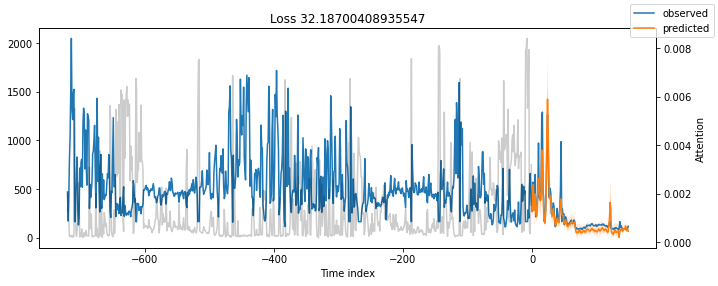

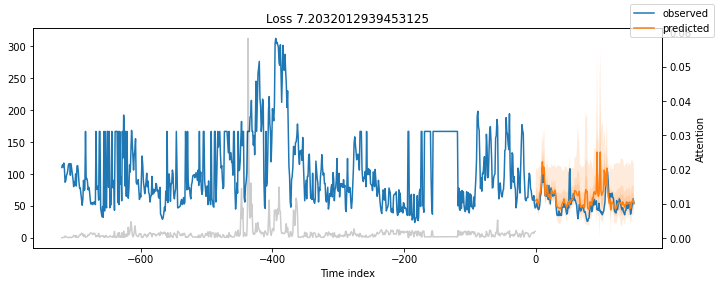

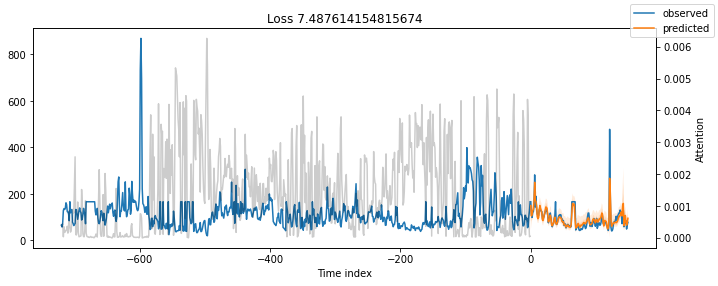

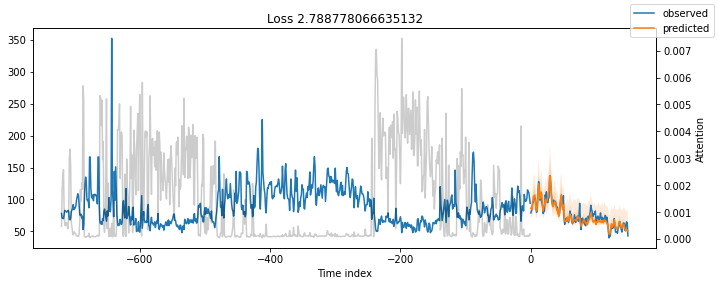

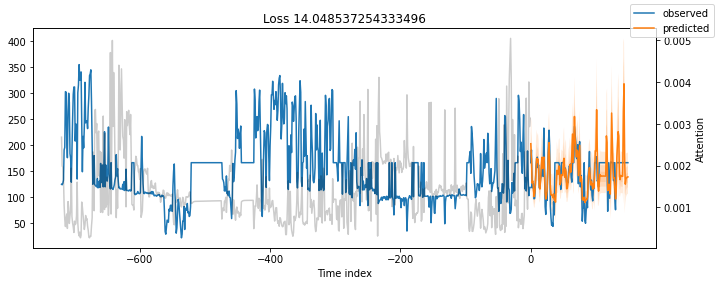

In [ ]:
for idx in range(5):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True,ax=ax)

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="quantiles", return_x=True)

In [ ]:
#for idx in range(10):  # plot 10 examples
    #best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

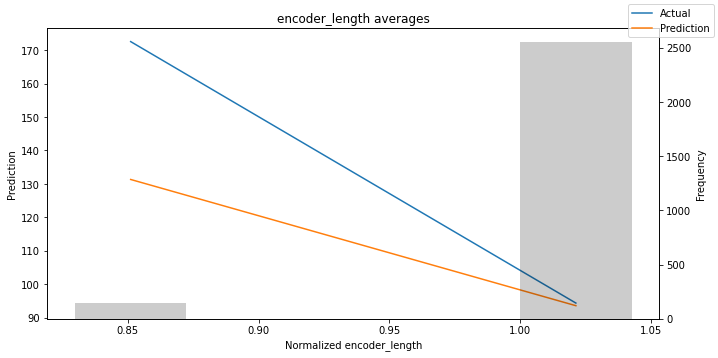

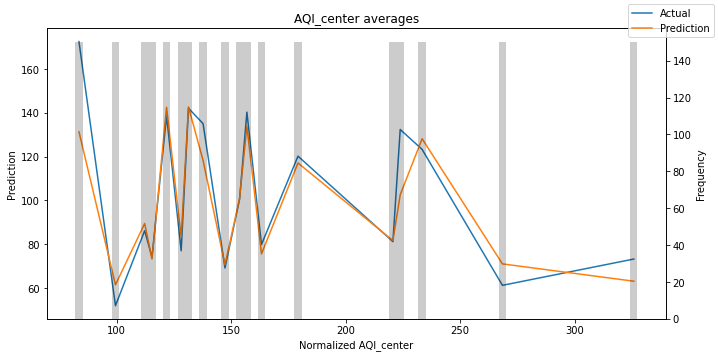

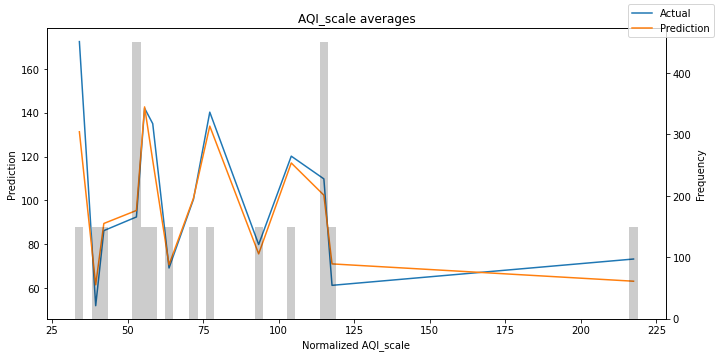

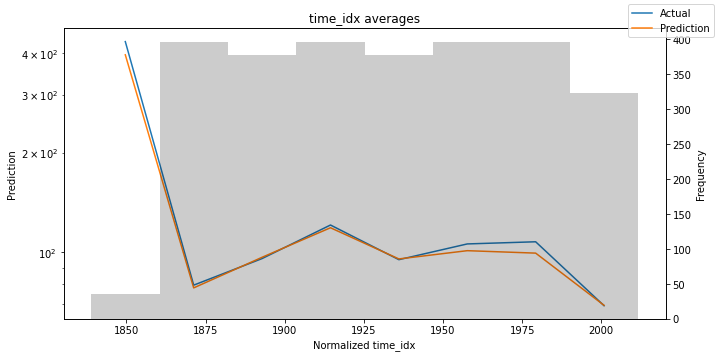

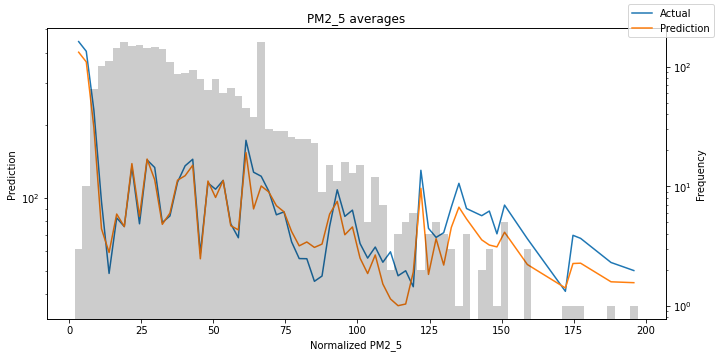

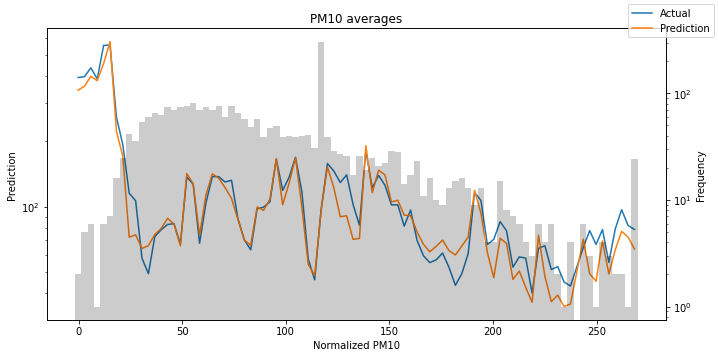

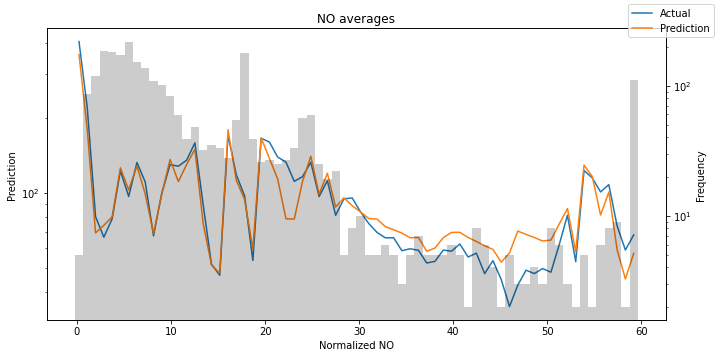

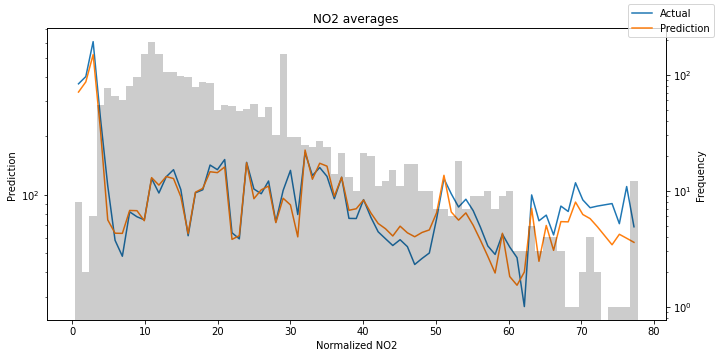

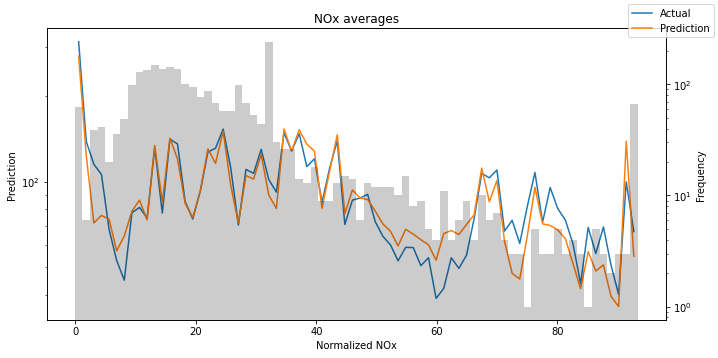

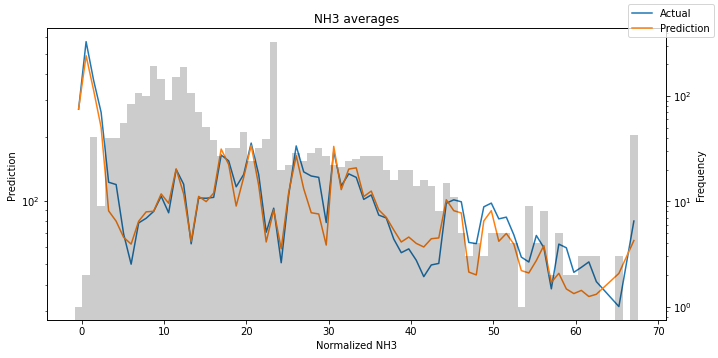

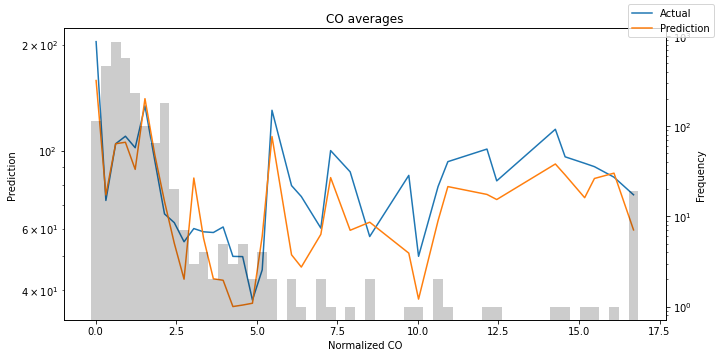

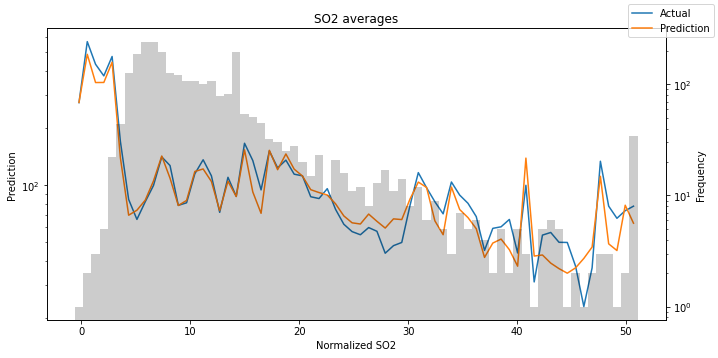

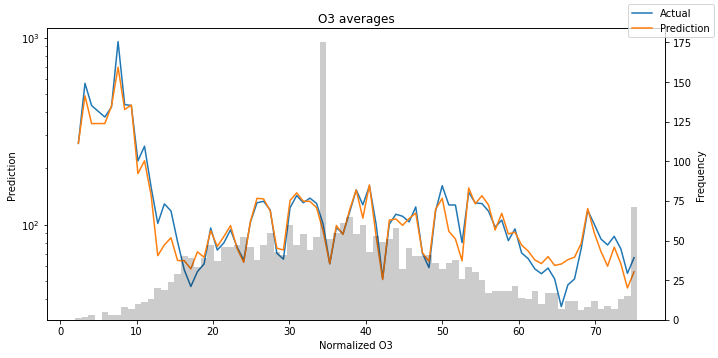

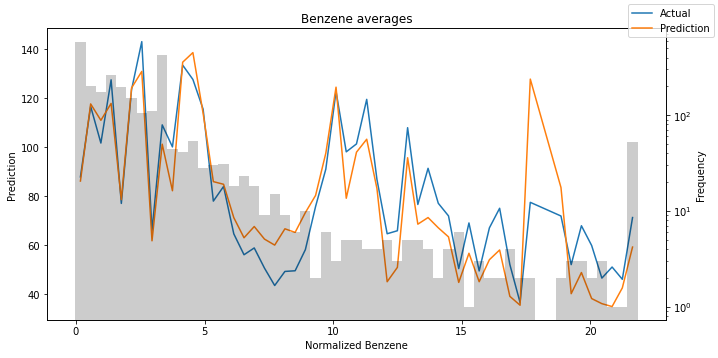

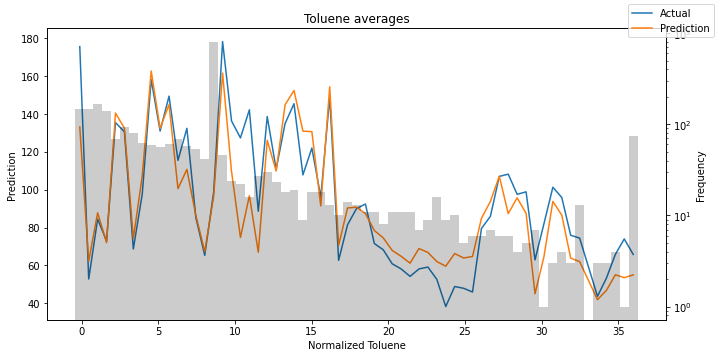

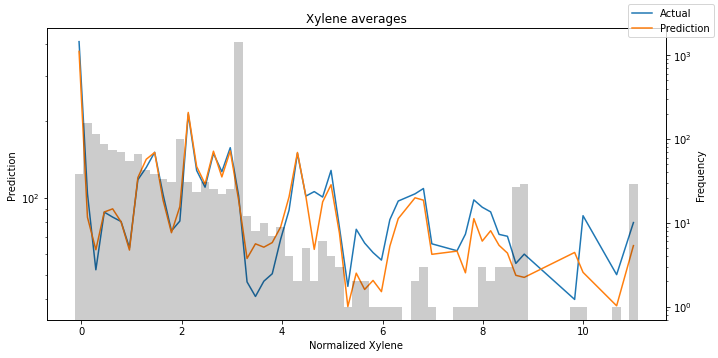

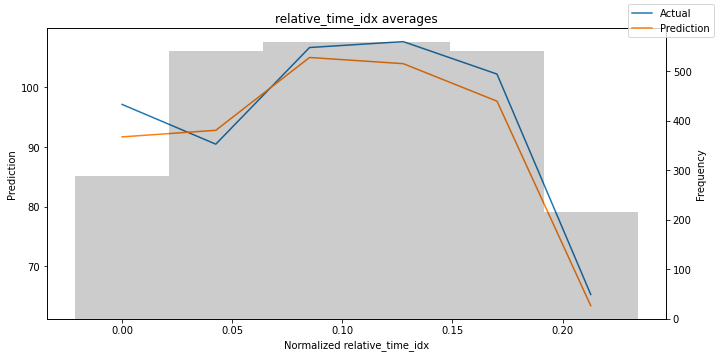

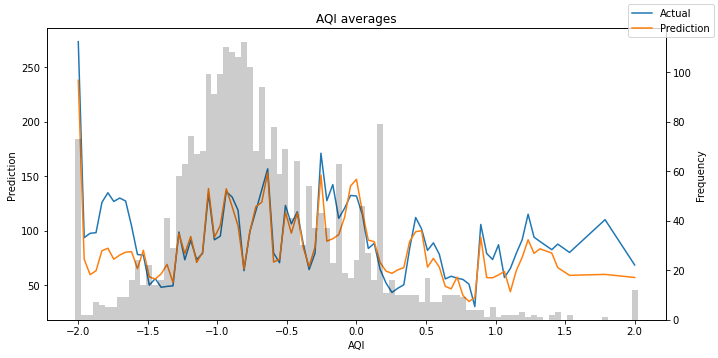

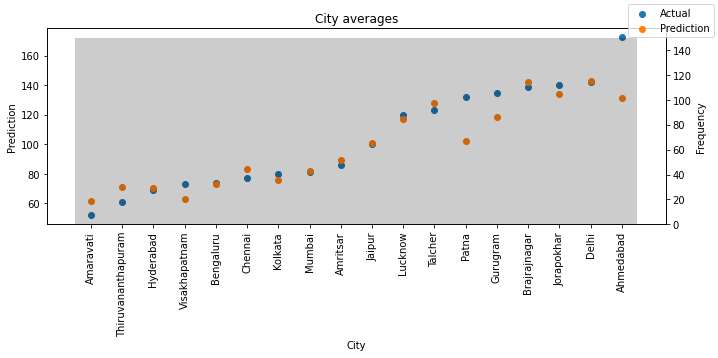

In [ ]:
predictions, x= best_tft.predict(val_dataloader,mode ="prediction" ,return_x=True)

predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

Forecasting Data for Ahmedabad

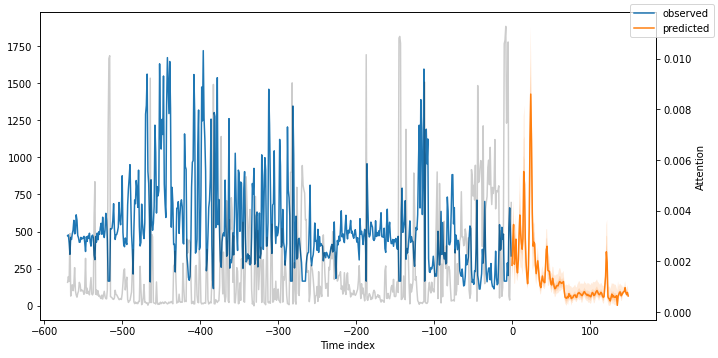

In [ ]:

encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the data
# in a real world dataset, 
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(Date=lambda x: x.Date + pd.offsets.DateOffset(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
#decoder_data["time_idx"] = decoder_data["Date"].dt.year * 12 + decoder_data["Date"].dt.month


Date1 = decoder_data['Date'].min()
decoder_data["time_idx"] = decoder_data['Date'] - Date1
decoder_data["time_idx"] = decoder_data["time_idx"].dt.days
#decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
#decoder_data["month"] = decoder_data.Date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
fig, ax = plt.subplots(figsize=(10, 5))

#create out-of-sample predictions for MT_002
new_prediction_data=new_prediction_data.query(" City == 'Ahmedabad'")#Change the city here
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)
best_tft.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False, ax=ax);

Forecasting Data for Chennai

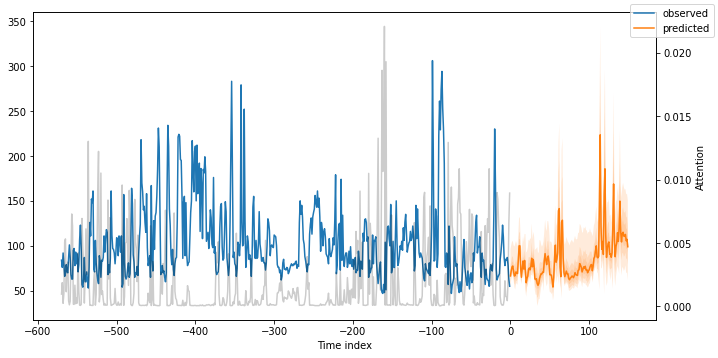

In [ ]:
# select last 24 days from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the data
# in a real world dataset, 
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(Date=lambda x: x.Date + pd.offsets.DateOffset(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
#decoder_data["time_idx"] = decoder_data["Date"].dt.year * 12 + decoder_data["Date"].dt.month


Date1 = decoder_data['Date'].min()
decoder_data["time_idx"] = decoder_data['Date'] - Date1
decoder_data["time_idx"] = decoder_data["time_idx"].dt.days
#decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
#decoder_data["month"] = decoder_data.Date.dt.month.astype(str).astype("category")  # categories have be strings
# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
fig, ax = plt.subplots(figsize=(10, 5))

#create out-of-sample predictions for MT_002
new_prediction_data1=new_prediction_data.query(" City == 'Chennai'")#Change the city here
new_raw_predictions1, new_x1 = best_tft.predict(new_prediction_data1, mode="raw", return_x=True)
best_tft.plot_prediction(new_x1, new_raw_predictions1, idx=0, show_future_observed=False, ax=ax);

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
x1=(((actuals - predictions).abs())/actuals.abs())
x1.mean()

tensor(0.1508)

In [ ]:
#Mean average absolute error
m1=(predictions - actuals).abs()
m1.mean()

tensor(16.0694)

In [ ]:
#SMAPE -  Symmetric mean absolute percentage
s1=2*(actuals - predictions).abs() / (actuals.abs() + predictions.abs()+ 1e-8)
s1.mean()

tensor(0.1493)

In [ ]:
#RMSE
r1=(predictions - actuals)**2
r1
r1=r1.mean()
r1=r1.sqrt()
accuracy = 1.96*r1
print(r1)
print(accuracy)

tensor(29.7565)
tensor(58.3227)
